# Losing aerobic habitat

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product

import cartopy
import cartopy.crs as ccrs
import cmocean
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import operators as ops
import util
import xarray as xr

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
curator = util.curator_local_assets()
catalog = curator.open_catalog()
curator

dict_keys(['ASM-Tmax-1x1', 'aerobic-habitat-change', 'cesm-le-epoch-means', 'cesm-le-global-ts', 'trait-space', 'trait-space-hires', 'viable-traits-mask-cesm-1x1', 'viable-traits-mask-woa2018', 'woa2018', 'zonal-safety-margin-metrics-cesm1x1', 'zonal-safety-margin-metrics-woa2018'])

In [4]:
ds_map = catalog['cesm-le-epoch-means'].to_dask().compute()
ds_map['TLAT'] = ds_map.TLAT[0, :, :]
ds_map['TLONG'] = ds_map.TLONG[0, :, :]

ds_map = util.pop_add_cyclic(ds_map).set_coords(['TLAT', 'TLONG'])
ds_map

<xarray.Dataset>
Dimensions:    (nlat: 384, nlon: 321, epoch: 2, member_id: 32)
Coordinates:
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 80.31 80.31 80.31
    TLONG      (nlat, nlon) float64 -220.6 -219.4 -218.3 ... -39.57 -39.86
  * epoch      (epoch) <U12 'ref_climate' '2100_climate'
  * member_id  (member_id) int64 2 9 10 11 12 13 14 ... 35 101 102 103 104 105
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP       (epoch, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pO2        (epoch, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [6]:
ds_hab = catalog['aerobic-habitat-change'].to_dask().compute()

ds_hab = util.pop_add_cyclic(ds_hab).set_coords(['TLAT', 'TLONG'])
ds_hab

<xarray.Dataset>
Dimensions:                  (nlat: 384, nlon: 321, member_id: 32, time: 181)
Coordinates:
    TLAT                     (nlat, nlon) float64 -79.22 -79.22 ... 80.31 80.31
    TLONG                    (nlat, nlon) float64 -220.6 -219.4 ... -39.86
    epoch                    <U11 'ref_climate'
  * member_id                (member_id) int64 2 9 10 11 12 ... 102 103 104 105
  * time                     (time) int64 1920 1921 1922 1923 ... 2098 2099 2100
    units                    <U1 '%'
Dimensions without coordinates: nlat, nlon
Data variables:
    aero_hab_glb             (time, member_id) float64 86.58 86.58 ... 78.58
    aero_hab_glb_normalized  (time, member_id) float64 0.1229 0.1243 ... -9.123
    habitat_change           (nlat, nlon) float64 nan nan nan ... nan nan nan
    habitat_var_change       (nlat, nlon) float64 nan nan nan ... nan nan nan

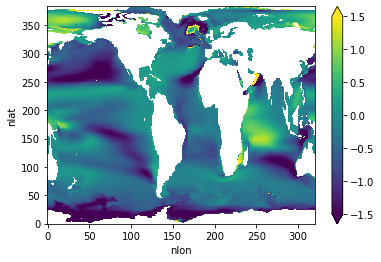

In [7]:
ΔT = ds_map.TEMP.sel(epoch='2100_climate') - ds_map.TEMP.sel(epoch='ref_climate')
ΔpO2 = ds_map.pO2.sel(epoch='2100_climate') - ds_map.pO2.sel(epoch='ref_climate')

(ΔpO2 / ΔT).plot(vmin=-1.5, vmax=1.5);

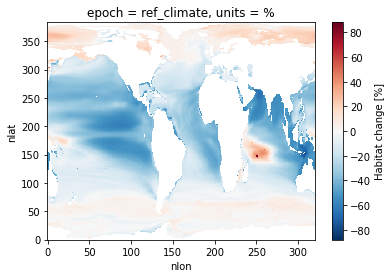

In [8]:
ds_hab.habitat_change.plot()

In [16]:
ds_hab.aero_hab_glb.attrs['units']

'10$^6$ km$^3$'

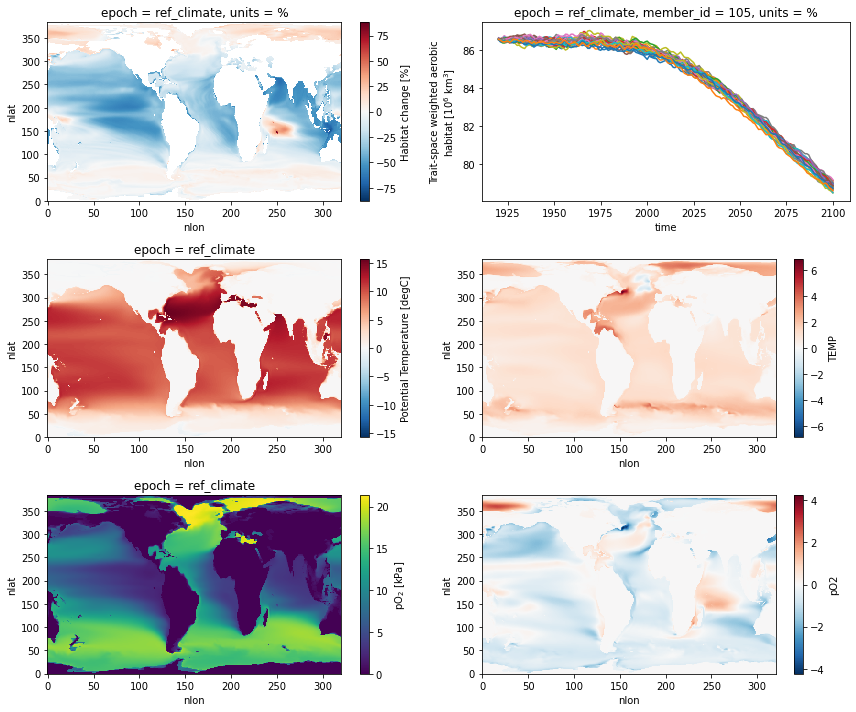

In [12]:
plot_data = [
    ds_hab.habitat_change,
    None,
    ds_map.TEMP.sel(epoch='ref_climate'),
    ds_map.TEMP.sel(epoch='2100_climate') - ds_map.TEMP.sel(epoch='ref_climate'),
    ds_map.pO2.sel(epoch='ref_climate'),
    ds_map.pO2.sel(epoch='2100_climate') - ds_map.pO2.sel(epoch='ref_climate'),
]

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
skip = 0
for n, field in enumerate(plot_data):
    if field is None:
        continue
    i, j = np.unravel_index(n + skip, axs.shape)
    field.plot(ax=axs[i, j])

for member_id in ds_hab.member_id.values:
    ds_hab.sel(member_id=member_id).aero_hab_glb.plot(ax=axs[0, 1])
plt.tight_layout()

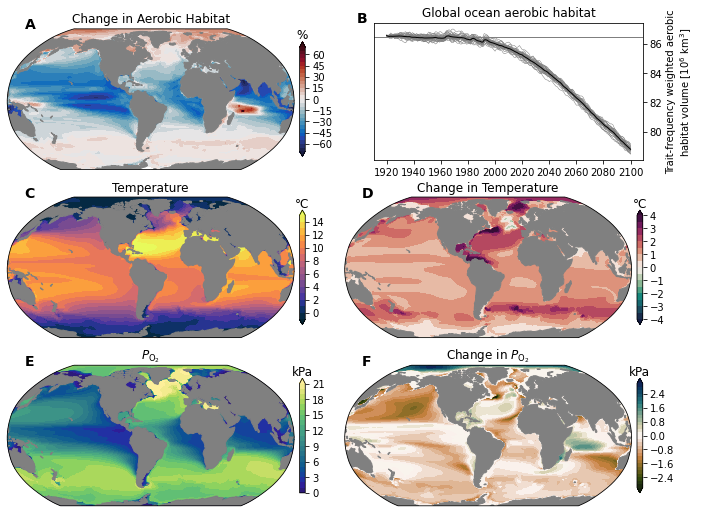

In [22]:
fig = plt.figure(figsize=(12, 9))
prj = ccrs.Robinson(central_longitude=305.0)

nrow, ncol = 3, 2
gs = gridspec.GridSpec(
    nrows=nrow,
    ncols=ncol * 3,
    width_ratios=(1, 0.02, 0.1) * ncol,
    wspace=0.05,
    hspace=0.1,
)

axs = np.empty((nrow, ncol)).astype(object)
caxs = np.empty((nrow, ncol)).astype(object)

for i, j in product(range(nrow), range(ncol)):
    if i == 0 and j == 1:
        axs[i, j] = plt.subplot(gs[i, j * 3 : j * 3 + 2])
        p = axs[i, j].get_position()
        h = p.height * 0.9
        d = p.height - h
        axs[i, j].set_position([p.x0 + p.width * 0.1, p.y0 + d, p.width * 0.9, h])
    else:
        axs[i, j] = plt.subplot(gs[i, j * 3], projection=prj)
        caxs[i, j] = plt.subplot(gs[i, j * 3 + 1])
        p = caxs[i, j].get_position()
        h = p.height * 0.75
        d = p.height - h
        caxs[i, j].set_position([p.x0, p.y0 + d / 2, p.width, h])

spec = [
    dict(levels=np.arange(-70, 75, 5), extend="both", cmap=cmocean.cm.balance),
    None,
    dict(levels=np.arange(-1, 16, 1), extend="both", cmap=cmocean.cm.thermal),
    dict(levels=np.arange(-4, 4.5, 0.5), extend="both", cmap=cmocean.cm.curl),
    dict(levels=np.arange(0, 22, 1), extend="max", cmap=cmocean.cm.haline),
    dict(levels=np.arange(-3, 3.2, 0.2), extend="both", cmap=cmocean.cm.tarn),
]

titles = [
    "Change in Aerobic Habitat",
    None,
    "Temperature",
    "Change in Temperature",
    r"$P_{\mathrm{O}_2}$",
    r"Change in $P_{\mathrm{O}_2}$",
]

cax_titles = [
    "%",
    None,
    "°C",
    "°C",
    "kPa",
    "kPa",
]

cf = []
for n, dsp in enumerate(plot_data):
    if dsp is None:
        continue
    i, j = np.unravel_index(n, axs.shape)
    ax = axs[i, j]

    cf = ax.contourf(
        dsp.TLONG,
        dsp.TLAT,
        dsp,
        transform=ccrs.PlateCarree(),
        **spec[n],
    )
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            "physical", "land", "110m", edgecolor="face", facecolor="gray"
        )
    )
    cb = plt.colorbar(cf, cax=caxs[i, j])  # , ticks=log_levels)
    ax.set_title(titles[n])
    cb.ax.set_title(cax_titles[n], y=1.02)


i, j = 0, 1
ax = axs[i, j]
for member_id in ds_hab.member_id.values:
    ax.plot(
        ds_hab.aero_hab_glb.time,
        ds_hab.aero_hab_glb.sel(member_id=member_id),
        linestyle="-",
        color="gray",
        linewidth=0.5,
    )
ax.plot(
    ds_hab.aero_hab_glb.time,
    ds_hab.aero_hab_glb.mean("member_id"),
    "-",
    color="k",
    linewidth=1,
)
ax.axhline(
    ds_hab.aero_hab_glb.sel(time=slice('1920', '1965')).mean(["member_id", "time"]),
    linewidth=0.5,
    color='k',
    zorder=-100,
)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_title("Global ocean aerobic habitat")
ax.set_ylabel(
    f"Trait-frequency weighted aerobic\nhabitat volume [{ds_hab.aero_hab_glb.attrs['units']}]"
)
ax.set_xticks(np.arange(1920, 2120, 20))
# ax.set_xlabel('Year')

util.label_plots(
    fig, [ax for ax in axs.ravel()], xoff=[0.02, -0.02, 0.02, 0.02, 0.02, 0.02], yoff=0
)

In [21]:
ds_hab

<xarray.Dataset>
Dimensions:                  (nlat: 384, nlon: 321, member_id: 32, time: 181)
Coordinates:
    TLAT                     (nlat, nlon) float64 -79.22 -79.22 ... 80.31 80.31
    TLONG                    (nlat, nlon) float64 -220.6 -219.4 ... -39.86
    epoch                    <U11 'ref_climate'
  * member_id                (member_id) int64 2 9 10 11 12 ... 102 103 104 105
  * time                     (time) int64 1920 1921 1922 1923 ... 2098 2099 2100
    units                    <U1 '%'
Dimensions without coordinates: nlat, nlon
Data variables:
    aero_hab_glb             (time, member_id) float64 86.58 86.58 ... 78.58
    aero_hab_glb_normalized  (time, member_id) float64 0.1229 0.1243 ... -9.123
    habitat_change           (nlat, nlon) float64 nan nan nan ... nan nan nan
    habitat_var_change       (nlat, nlon) float64 nan nan nan ... nan nan nan